# 多步多变量时间序列的LSTM模型预测——基于Keras

##### lwb-xmu

## 一、模型准备

### 1.1 加载需要的包

In [10]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import pandas as pd
import numpy as np

### 1.2 定义将时间序列预测问题转化为监督学习问题的函数

In [11]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = [], []
    #i: n_in, n_in-1, ..., 1，为滞后期数
    #分别代表t-n_in, ... ,t-1期
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    #i: 0, 1, ..., n_out-1，为超前预测的期数
    #分别代表t，t+1， ... ,t+n_out-1期
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    agg = concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg

### 1.3 定义准备数据的函数

In [12]:
def prepare_data(filepath, n_in, n_out=30, n_vars=4, train_proportion=0.8):
    #读取数据集
    dataset = read_csv(filepath, encoding='utf-8')
    #设置时间戳索引
    dataset['日期'] = pd.to_datetime(dataset['日期'])
    dataset.set_index("日期", inplace=True)
    values = dataset.values
    #保证所有数据都是float32类型
    values = values.astype('float32')
    #变量归一化
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(values)
    #将时间序列问题转化为监督学习问题
    reframed = series_to_supervised(scaled, n_in, n_out)
    #取出保留的变量
    contain_vars = []
    for i in range(1, n_in+1):
        contain_vars += [('var%d(t-%d)' % (j, i)) for j in range(1,n_vars+1)]  
    data = reframed [ contain_vars + ['var1(t)'] + [('var1(t+%d)' % (j)) for j in range(1,n_out)]]
    #修改列名
    col_names = ['Y', 'X1', 'X2', 'X3']
    contain_vars = []
    for i in range(n_vars):
        contain_vars += [('%s(t-%d)' % (col_names[i], j)) for j in range(1,n_in+1)]  
    data.columns = contain_vars +  ['Y(t)'] + [('Y(t+%d)' % (j)) for j in range(1,n_out)]
    #分隔数据集，分为训练集和测试集
    values = data.values
    n_train = round(data.shape[0]*train_proportion)
    train = values[:n_train, :]
    test = values[n_train:, :]
    #分隔输入X和输出y
    train_X, train_y = train[:, :n_in*n_vars], train[:, n_in*n_vars:]
    test_X, test_y = test[:, :n_in*n_vars], test[:, n_in*n_vars:]
    #将输入X改造为LSTM的输入格式，即[samples,timesteps,features]
    train_X = train_X.reshape((train_X.shape[0], n_in, n_vars))
    test_X = test_X.reshape((test_X.shape[0], n_in, n_vars))
    return scaler, data, train_X, train_y, test_X, test_y, dataset

### 1.4 定义拟合LSTM模型的函数

In [13]:
def fit_lstm(data_prepare, n_neurons=50, n_batch=72, n_epoch=100, loss='mae', optimizer='adam', repeats=1):
    train_X = data_prepare[2]
    train_y = data_prepare[3]
    test_X = data_prepare[4]
    test_y = data_prepare[5]
    model_list = []
    for i in range(repeats):
        #设计神经网络
        model = Sequential()
        model.add(LSTM(n_neurons, input_shape=(train_X.shape[1], train_X.shape[2])))
        model.add(Dense(train_y.shape[1]))
        model.compile(loss=loss, optimizer=optimizer)
        #拟合神经网络
        history = model.fit(train_X, train_y, epochs=n_epoch, batch_size=n_batch, validation_data=(test_X, test_y), verbose=0, shuffle=False)
        #画出学习过程
        p1 = pyplot.plot(history.history['loss'], color='blue', label='train')
        p2 = pyplot.plot(history.history['val_loss'], color='yellow',label='test')
        #保存model
        model_list.append(model)
    pyplot.legend(["train","test"])
    pyplot.show()
    return model_list

### 1.5 定义预测的函数

In [14]:
def lstm_predict(model, data_prepare):
    scaler = data_prepare[0]
    test_X = data_prepare[4]
    test_y = data_prepare[5]
    #做出预测
    yhat = model.predict(test_X)
    #将测试集上的预测值还原为原来的数据维度
    scale_new = MinMaxScaler()
    scale_new.min_, scale_new.scale_ = scaler.min_[0], scaler.scale_[0]
    inv_yhat = scale_new.inverse_transform(yhat)
    #将测试集上的实际值还原为原来的数据维度
    inv_y = scale_new.inverse_transform(test_y)
    return inv_yhat, inv_y

### 1.6 定义预测评价的函数（RMSE）

In [18]:
# 计算每一步预测的RMSE
def evaluate_forecasts(test, forecasts, n_out):
    rmse_dic = {}
    for i in range(n_out):
        actual = [float(row[i]) for row in test]
        predicted = [float(forecast[i]) for forecast in forecasts]
        rmse = sqrt(mean_squared_error(actual, predicted))
        rmse_dic['t+' + str(i+1) + ' RMSE'] = rmse
    return rmse_dic

### 1.7 定义将预测可视化的函数

In [19]:
#以原始数据为背景画出预测数据
def plot_forecasts(series, forecasts):
    #用蓝色画出原始数据集
    pyplot.plot(series.values)
    n_seq = len(forecasts[0])
    #用红色画出预测值
    for i in range(1,len(forecasts)+1):
        xaxis = [x for x in range(i, i+n_seq+1)]
        yaxis = [float(series.iloc[i-1,0])] + list(forecasts[i-1])
        pyplot.plot(xaxis, yaxis, color='red')
    #展示图像
    pyplot.show()

## 二、模型建立

### 2.1 建立模型（n_in = 15，n_neuron = 5，n_batch = 16，n_epoch = 200）

#### 为了减少随机性，重复建立五次模型，取五次结果的平均作为最后的预测

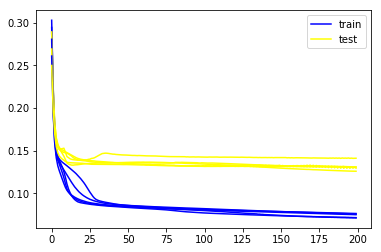

In [35]:
#定义需要的变量
filepath = r'导出文件.csv'
n_in = 15
n_out = 30
n_vars = 4
n_neuron = 5
n_batch = 16
n_epoch = 200
repeats = 5

inv_yhat_list = []
inv_y_list = []


data_prepare = prepare_data(filepath,n_in, n_out)
scaler, data, train_X, train_y, test_X, test_y, dataset = data_prepare
model_list = fit_lstm(data_prepare, n_neuron, n_batch, n_epoch,repeats=repeats)
for i in range(len(model_list)):
    model = model_list[i]
    inv_yhat = lstm_predict(model, data_prepare)[0]
    inv_y = lstm_predict(model, data_prepare)[1]
    inv_yhat_list.append(inv_yhat)
    inv_y_list.append(inv_y)

#### 求出平均预测结果

In [36]:
inv_yhat_ave = np.zeros(inv_y.shape)

for i in range(repeats):
    inv_yhat_ave += inv_yhat_list[i]
    
inv_yhat_ave = inv_yhat_ave/repeats

### 2.2 模型评价

#### 最终平均预测结果inv_yhat_ave的每步预测RMSE

In [37]:
rmse_dic_list = []
for i in range(len(model_list)):
    inv_yhat = inv_yhat_list[i]
    inv_y = inv_y_list[i]
    rmse_dic = evaluate_forecasts(inv_y, inv_yhat, n_out)
    rmse_dic_list.append(rmse_dic)

rmse_dic_list.append(evaluate_forecasts(inv_y, inv_yhat_ave, n_out))

In [38]:
df_dic = {}
for i in range(len(rmse_dic_list) - 1):
    df_dic['第' + str(i+1) + '次'] = pd.Series(rmse_dic_list[i])
    
df_dic['平均'] = pd.Series(rmse_dic_list[i+1])
rmse_df = DataFrame(df_dic)
rmse_df

,第1次,第2次,第3次,第4次,第5次,平均
t+1 RMSE,6.054318,5.910827,6.574757,5.514524,5.930769,5.608112
t+2 RMSE,6.799496,5.919717,7.129066,5.930466,6.346187,6.065158
t+3 RMSE,6.961642,6.410686,7.275462,6.546540,6.857233,6.618044
t+4 RMSE,7.707383,6.725169,7.962916,7.179770,7.364481,7.175948
t+5 RMSE,8.543821,7.359477,8.997917,7.591111,8.004835,7.831434
t+6 RMSE,8.826944,8.790049,9.158018,8.390160,8.501117,8.547602
t+7 RMSE,9.372653,8.842808,9.847240,8.818847,8.995596,9.000587
t+8 RMSE,9.869172,9.206043,10.790298,9.389183,9.621195,9.657852
t+9 RMSE,10.224256,10.113056,11.275415,9.925362,10.320555,10.177834
t+10 RMSE,10.730779,10.613619,11.738241,10.547615,10.858770,10.750603


#### 最终平均预测结果inv_yhat_ave的每步预测错误率的平均，平均来看，预测结果会比真实结果偏高。

In [39]:
s = inv_yhat_ave[0].shape
erro_rate = np.zeros(s)
for i in range(len(inv_y)):
    erro_rate += inv_yhat_ave[i]/inv_y[i]-1

erro_rate_ave = erro_rate/len(inv_y)
err_df = DataFrame(pd.Series(erro_rate_ave))
err_df.columns = ['平均预测错误率']
err_df.index = ['超前%d步预测' % (i+1) for i in range(n_out)]
err_df

,平均预测错误率
超前1步预测,0.046550
超前2步预测,0.047578
超前3步预测,0.050722
超前4步预测,0.052867
超前5步预测,0.059091
超前6步预测,0.063377
超前7步预测,0.064786
超前8步预测,0.064920
超前9步预测,0.065614
超前10步预测,0.066760


### 2.3 预测结果可视化

#### 测试集的前十个样本

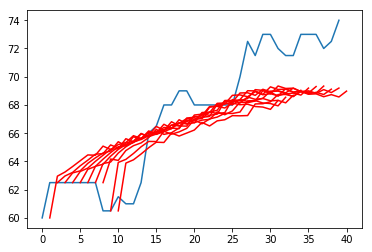

In [40]:
dataset = data_prepare[6]
test_X = data_prepare[4]
n_real = len(dataset)-len(test_X)-len(inv_yhat_ave[0])
#多画一个
y_real = DataFrame(dataset['Y'][n_real:n_real+10+30])
plot_forecasts(y_real, inv_yhat_ave[0:10])

#### 整个测试集

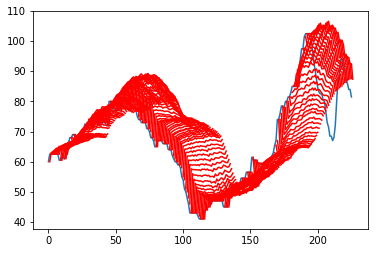

In [41]:
n_real = len(dataset)-len(test_X)-len(inv_yhat[0])
#多画一个
y_real = DataFrame(dataset['Y'][n_real:])
plot_forecasts(y_real, inv_yhat_ave)

### 2.4 结果导出

#### Yhat

In [137]:
pre_df = DataFrame(inv_yhat_ave)
#时间戳处理，让它只显示到日
date_index = dataset.index[n_in-1+len(train_X)-1:n_in-1+len(train_X)+len(test_X)-1]
pydate_array = date_index.to_pydatetime()
date_only_array = np.vectorize(lambda s: s.strftime('%Y-%m-%d'))(pydate_array )
date_only_series = pd.Series(date_only_array)
pre_df = pre_df.set_index(date_only_series)
names_columns = ['未来%d期' % (i+1) for i in range(n_out)]
pre_df.columns = names_columns
pre_df = pre_df.round(decimals=2)#小数点

#### Y

In [136]:
actual_df = DataFrame(inv_y)
names_columns = ['未来%d期' % (i+1) for i in range(n_out)]
actual_df.columns = names_columns
actual_df = actual_df.set_index(date_only_series)
actual_df = actual_df.round(decimals=2)

#### 导出xlsx

In [140]:
writer = pd.ExcelWriter('Y-结果导出.xlsx')
pre_df.to_excel(writer,"Yhat")
actual_df.to_excel(writer,"Y")
writer.save()

## 参考资料：
https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/

https://blog.csdn.net/qq_28031525/article/details/79046718

https://cloud.tencent.com/developer/article/1645547

https://machinelearningmastery.com/update-lstm-networks-training-time-series-forecasting/